Total contours found: 25


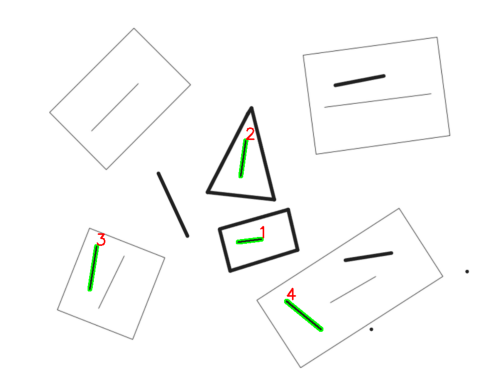

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
image = cv2.imread('triangle.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours and hierarchy
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_image = image.copy()

inner_lines = []
print("Total contours found:", len(contours))

# Loop through all contours
for i, cnt in enumerate(contours):
    parent = hierarchy[0][i][3]  # parent contour index
    child = hierarchy[0][i][2]   # first child contour index

    # Select contours that have a parent but no children (likely inner lines)
    if parent != -1 and child == -1:
        perimeter = cv2.arcLength(cnt, True)
        inner_lines.append((perimeter, i))  # store (perimeter, contour index)

# Sort by perimeter (shortest first)
inner_lines.sort(key=lambda x: x[0])

# Create mapping from contour index to numbering
line_numbers = {contour_index: i + 1 for i, (_, contour_index) in enumerate(inner_lines)}

# Draw and label only the first four smallest lines
for perimeter, contour_index in inner_lines[:4]:
    contour = contours[contour_index]
    cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)  # green
    number = line_numbers[contour_index]
    cv2.putText(contour_image, str(number), tuple(contour[0][0]),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)  # red

# Show the result
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


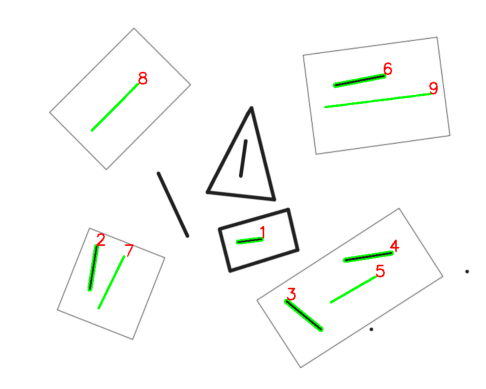

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
image = cv2.imread('triangle.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours and hierarchy
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_image = image.copy()

# Step 1: Detect rectangles (outer shapes)
rectangles = []
for i, cnt in enumerate(contours):
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    if len(approx) == 4:  # 4 corners → rectangle
        x, y, w, h = cv2.boundingRect(cnt)
        rectangles.append((x, y, w, h, i))  # store rect and contour index

inner_lines = []

# Step 2: Find lines inside rectangles
for i, cnt in enumerate(contours):
    parent = hierarchy[0][i][3]  # parent contour index
    child = hierarchy[0][i][2]   # first child contour index
    
    if parent != -1 and child == -1:
        # Bounding box of the line
        lx, ly, lw, lh = cv2.boundingRect(cnt)
        
        # Check if this line is inside any detected rectangle
        for rx, ry, rw, rh, rect_idx in rectangles:
            if rx < lx and ry < ly and (lx + lw) < (rx + rw) and (ly + lh) < (ry + rh):
                perimeter = cv2.arcLength(cnt, True)
                inner_lines.append((perimeter, i))
                break  # no need to check other rectangles

# Step 3: Sort and assign numbers
inner_lines.sort(key=lambda x: x[0])  # shortest first
line_numbers = {contour_index: i + 1 for i, (_, contour_index) in enumerate(inner_lines)}

# Step 4: Draw and label
for perimeter, contour_index in inner_lines:
    contour = contours[contour_index]
    cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)  # green
    number = line_numbers[contour_index]
    cv2.putText(contour_image, str(number), tuple(contour[0][0]),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)  # red

# Show the result
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


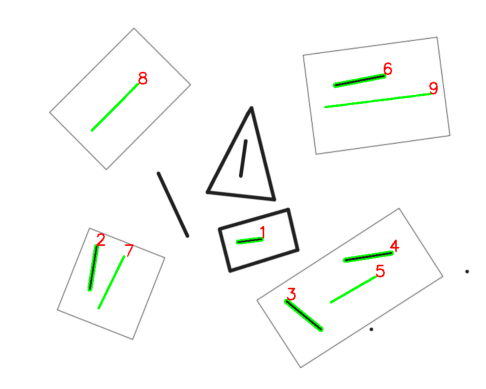

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import hypot
from itertools import combinations

# Function to calculate max pairwise distance inside contour points
def distance(pts):
    p = pts.reshape(-1, 2)
    maxd = 0.0
    for (x1, y1), (x2, y2) in combinations(p, 2):
        d = hypot(x2 - x1, y2 - y1)
        if d > maxd:
            maxd = d
    return maxd

# Load and preprocess image
image = cv2.imread('triangle.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours and hierarchy
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_image = image.copy()

# Step 1: Detect rectangles (outer shapes)
rectangles = []
for i, cnt in enumerate(contours):
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    if len(approx) == 4:  # 4 corners → rectangle
        x, y, w, h = cv2.boundingRect(cnt)
        rectangles.append((x, y, w, h, i))  # store rect and contour index

inner_lines = []

# Step 2: Find lines inside rectangles
for i, cnt in enumerate(contours):
    parent = hierarchy[0][i][3]  # parent contour index
    child = hierarchy[0][i][2]   # first child contour index
    
    if parent != -1 and child == -1:
        # Bounding box of the line
        lx, ly, lw, lh = cv2.boundingRect(cnt)
        
        # Check if this line is inside any detected rectangle
        for rx, ry, rw, rh, rect_idx in rectangles:
            if rx < lx and ry < ly and (lx + lw) < (rx + rw) and (ly + lh) < (ry + rh):
                # Use max pairwise distance instead of perimeter
                max_dist = distance(cnt)
                inner_lines.append((max_dist, i))
                break  # no need to check other rectangles

# Step 3: Sort and assign numbers
inner_lines.sort(key=lambda x: x[0])  # shortest first based on max pairwise distance
line_numbers = {contour_index: i + 1 for i, (_, contour_index) in enumerate(inner_lines)}

# Step 4: Draw and label
for max_dist, contour_index in inner_lines:
    contour = contours[contour_index]
    cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)  # green
    number = line_numbers[contour_index]
    # Put the number at the first point of contour (adjust as needed)
    cv2.putText(contour_image, str(number), tuple(contour[0][0]),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)  # red

# Show the result
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
